In [234]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scienceplots
from skfda.misc.covariances import Gaussian, Covariance
from skfda.datasets import make_gaussian_process
from skfda.misc.metrics import PairwiseMetric, l2_distance
plt.style.use('science')

In [235]:
class ExpSinSquared(Covariance):
    def __init__(
        self,
        variance: float = 1,
        length_scale: float = 1,
        period: float = 1
    ) -> None:
        self.variance = variance
        self.length_scale = length_scale
        self.period = period

    def __call__(self, x, y = None):
        """Compute exponential covariance function on input data."""
        x, y = self._param_check_and_transform(x, y)

        distance_x_y = PairwiseMetric(l2_distance)(x, y)
        return self.variance * np.exp(  # type: ignore[no-any-return]
            -2/(self.length_scale**2)*np.square(np.sin(np.pi*distance_x_y/self.period))
        )

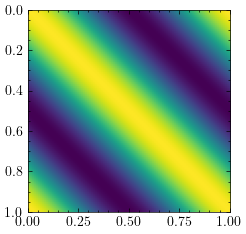

In [236]:
x = np.linspace(0,1,100).reshape(-1,1)
plt.imshow(ExpSinSquared(length_scale=10)(x,x), extent=[0,1,1,0])

In [237]:
N = 200 # number of points
n = 30 # number of samples/observations
p = 5 # number of variables/features

length_scale=8
variance=3

t = np.linspace(0,1, N)
x1 = make_gaussian_process(n_samples=n, n_features=N, start=0, stop=1, mean=1.5*np.sin(np.linspace(0,np.pi,N)), cov=ExpSinSquared(variance, length_scale))
x1 = (x1.data_matrix - x1.data_matrix[:,[0]])[:, :, 0].transpose(1,0)
x2 = make_gaussian_process(n_samples=n, n_features=N, start=0, stop=1, mean=-1.5*np.sin(np.linspace(0,np.pi,N)), cov=ExpSinSquared(variance, length_scale))
x2 = (x2.data_matrix - x2.data_matrix[:,[0]])[:, :, 0].transpose(1,0)
x0 = make_gaussian_process(n_samples=n, n_features=N, start=0, stop=1, mean=0, cov=ExpSinSquared(variance, length_scale))
x0 = (x0.data_matrix - x0.data_matrix[:,[0]])[:, :, 0].transpose(1,0)

x = np.concatenate([x1,x2,x0],axis=1).transpose()
values = np.concatenate([np.zeros(2*n), np.ones(n)])

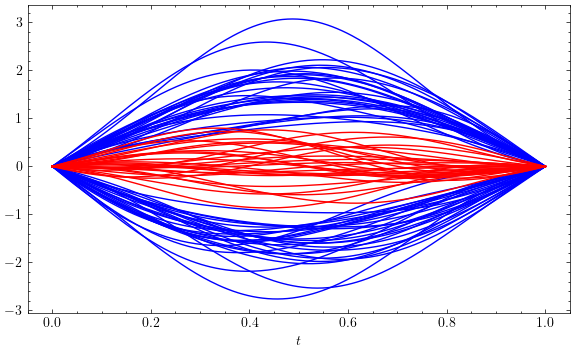

In [238]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(t, x1, color="blue")
ax.plot(t, x2, color="blue")
ax.plot(t, x0, color="red")
ax.set_xlabel('$t$')
plt.show()

In [239]:
def L2(x):
    dt = 1/(N-1)
    return np.sqrt(np.sum(np.square(x[:,:,1:]),axis=-1)*dt)


def RBF(x,y, variance=1):
    return np.exp(-L2(x-y)**2/(2*variance))

In [240]:
n = x.shape[0]

K = RBF(x.reshape(-1,1,N), x.reshape(1,-1,N))
print(K.shape)
one_n = np.ones((n, n)) / n
K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

(90, 90)


In [241]:
eigenvalues, eigenvectors = np.linalg.eigh(K_centered)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = np.take_along_axis(eigenvalues, idx, axis=-1)
eigenvectors = np.take_along_axis(eigenvectors, idx[np.newaxis,:], axis=-1)

In [242]:
k=2
alpha = eigenvectors[:, :k]/np.sqrt(eigenvalues[:k])
Z = K @ alpha

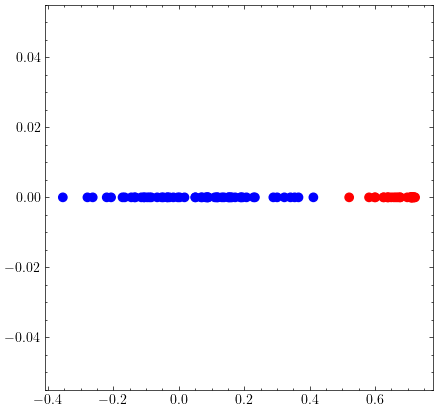

In [243]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(Z[:, 1], np.zeros(Z.shape[0]), c=values, cmap='bwr')

[]

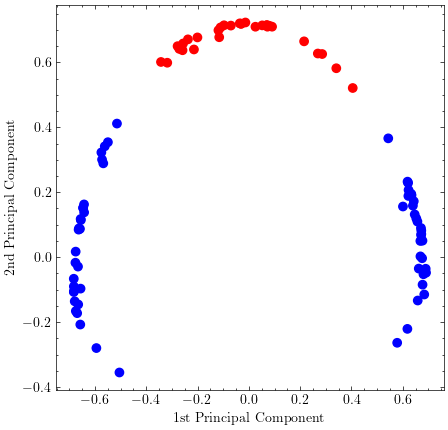

In [244]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(Z[:,0],Z[:, 1], c=values, cmap='bwr')
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
plt.plot()